In [1]:
import pandas as pd
import numpy as np

from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
sales=pd.read_csv('sales_prediction.csv')
sales.shape

(8523, 12)

In [3]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Separating independent and dependent variabes as x and y respectively

In [4]:
x=sales.drop(['Item_Outlet_Sales'], axis=1)
y=sales['Item_Outlet_Sales']
x.shape, y.shape

((8523, 11), (8523,))

### Preparing train and test datasets
Train and test datasets have been split with 70-30 ratio. There is no fixed rule to choose this ratio. It can be changed based on the problem we are solving. For example, if we have very less data, we can go for 90-10 ratio as we want to use as more data for training. But if we have more data, we can increase the ratio for test dataset say 20 or 30.

In [5]:
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.3, random_state=42 )

In [6]:
x_train.shape, x_test.shape

((5966, 11), (2557, 11))

#### Make a copy of the training data for explorations/cleaning/preprocessing

In [7]:
x_train_c=x_train.copy()

# EDA + Data Preprocessing + Feature Engineering

## Basic EDA 

In [8]:
x_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5966 entries, 1921 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5966 non-null   object 
 1   Item_Weight                4943 non-null   float64
 2   Item_Fat_Content           5966 non-null   object 
 3   Item_Visibility            5966 non-null   float64
 4   Item_Type                  5966 non-null   object 
 5   Item_MRP                   5966 non-null   float64
 6   Outlet_Identifier          5966 non-null   object 
 7   Outlet_Establishment_Year  5966 non-null   int64  
 8   Outlet_Size                4276 non-null   object 
 9   Outlet_Location_Type       5966 non-null   object 
 10  Outlet_Type                5966 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 559.3+ KB


In [9]:
# Checking for null values in train dataset
x_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                  1023
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [10]:
# Checking for null values in test dataset
x_test.isnull().sum()

Item_Identifier                0
Item_Weight                  440
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                  720
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

Both train and test datsets have null values in the colmuns 'item weight' and 'outlet_size'.

##### separating numerical and categorical variables

In [11]:
num_cols=x_train_c.describe().columns
cat_cols=x_train_c.describe(include='O').columns

##### checking basic statistics for numerical and categorical columns

In [12]:
x_train_c[num_cols].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4943.000000,5966.000000,5966.000000,5966.000000
mean,12.937193,0.065821,141.814242,1997.867248
std,4.630433,0.051093,62.627609,8.385023
min,4.555000,0.000000,31.290000,1985.000000
25%,8.895000,0.026982,94.144250,1987.000000
50%,12.650000,0.053923,143.879900,1999.000000
75%,17.000000,0.094350,186.621400,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


In [13]:
x_train_c[cat_cols].describe()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5966,5966,5966,5966,4276,5966,5966
unique,1543,5,16,10,3,3,4
top,FDF52,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,9,3535,905,668,1960,2367,3893


#### Visualizing numeric data for distributions and outliers

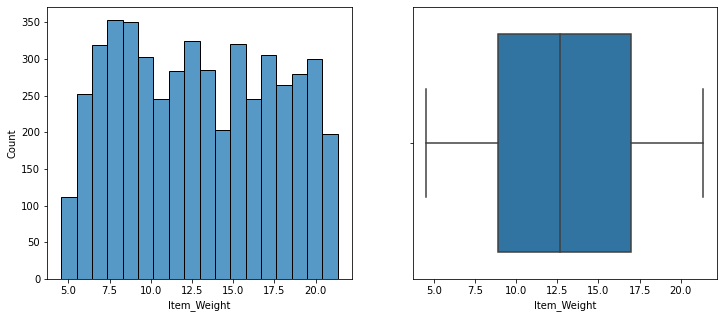

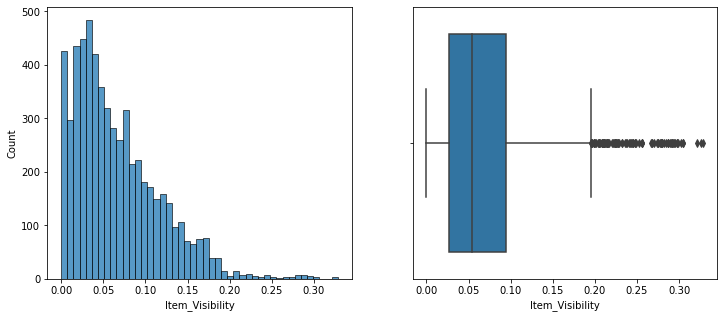

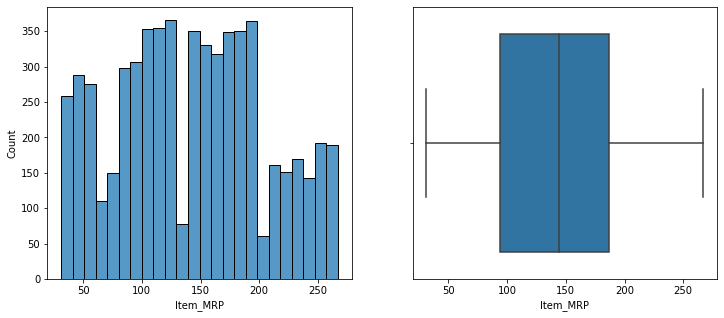

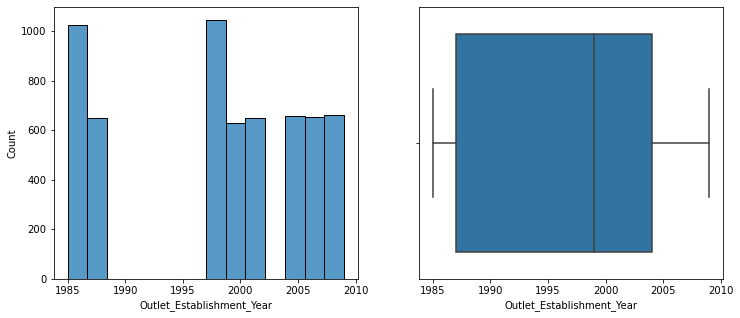

In [14]:
def visualize_num_cols(data, cols):
    for i in cols: 
        fig, ax=plt.subplots(1,2, figsize=(12,5))
        sns.histplot(data=data, x=i, ax=ax[0])
        sns.boxplot(data=data, x=i, ax=ax[1])
        
visualize_num_cols(x_train_c, num_cols)

-Item_Visibility has right skewed distribution. It means high visibility items are less in number. <br/>
-Item_MRP looks like a multimodal distribution. It is possible as different items have different price range.

### Visualizing categorical features

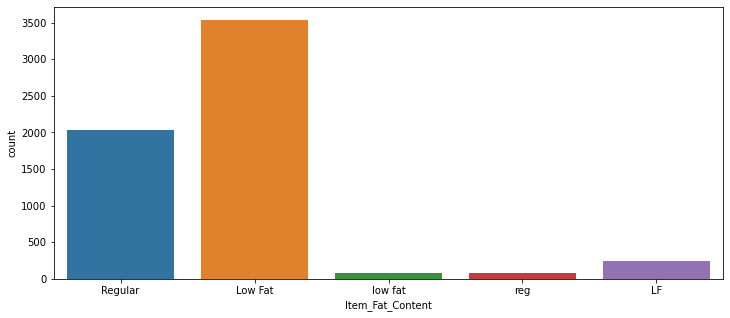

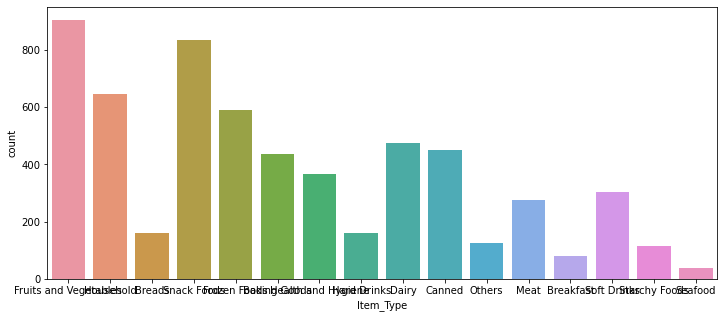

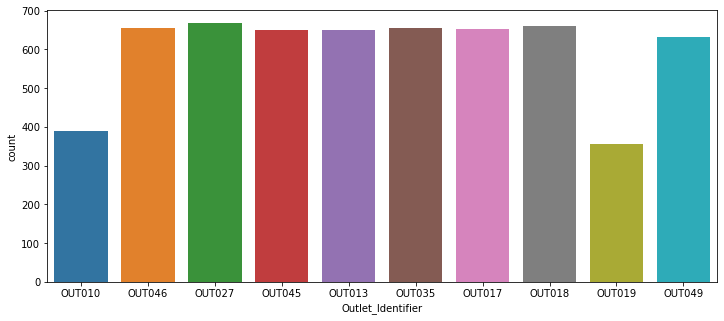

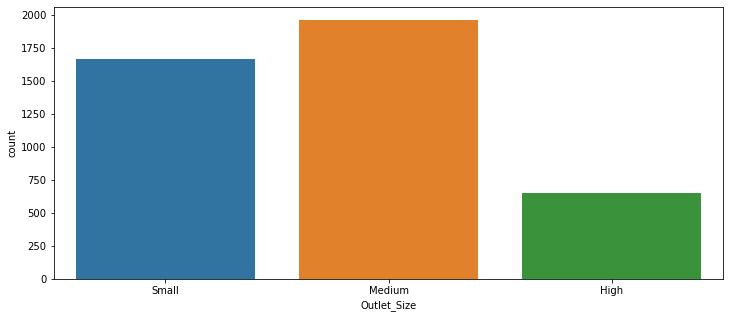

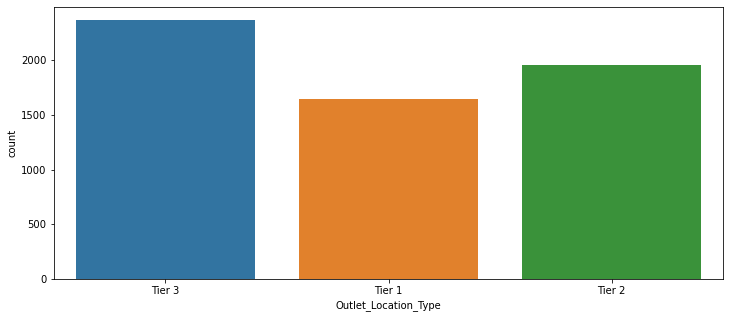

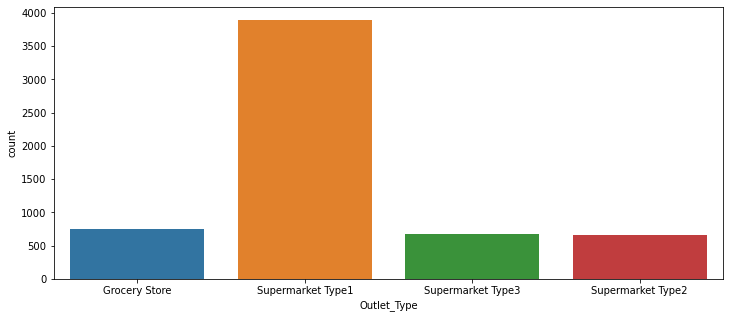

In [15]:
def visualize_cat_cols(data, cols):
    for i in cat_cols:
        if i != 'Item_Identifier':
            plt.subplots(figsize=(12,5))
            sns.countplot(data=data, x=i)
                
visualize_cat_cols(x_train_c, cat_cols)

#### Observations for categorical columns
-Item_Fat_Content has same categories with diifferent names (For example, Low Fat, low fat, LF for low fat items) . This needs correction. Also, most of the items are with low fat content. <br\>

-Item_Type has so many categories. Needs to see if the similar categories can be clubbed together and the number of categories can be reduced. <br\>

-Most of the outlets are of medium size.Though the number of small and medium sized outlets are close. <br\>

-Most of the outlets are in Tier3 cities and least number of outlets are in Tier1 cities. Though there is not much difference in the outlets of three categories.

-Most of the outlets are of Supermarket Type 1 and its number is significantly greater than other outlet types.


## Data Preprocessing

##### Step 1: Standardize Item_Fat_Content

In [16]:
x_train_c['Item_Fat_Content'].value_counts()

Low Fat    3535
Regular    2027
LF          243
low fat      82
reg          79
Name: Item_Fat_Content, dtype: int64

In [17]:
def standardize_item_fat_content(df):
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'})
    return df

standardize_item_fat_content(x_train_c)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,7.720,Regular,0.147904,Fruits and Vegetables,116.6466,OUT010,1998,NaN,Tier 3,Grocery Store
655,NCJ42,19.750,Low Fat,0.014301,Household,103.0332,OUT046,1997,Small,Tier 1,Supermarket Type1
2229,FDY47,NaN,Regular,0.054221,Breads,129.1310,OUT027,1985,Medium,Tier 3,Supermarket Type3
2537,FDN45,19.350,Low Fat,0.118342,Snack Foods,222.6088,OUT045,2002,NaN,Tier 2,Supermarket Type1
3528,FDY16,18.350,Regular,0.092150,Frozen Foods,184.8266,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...,...
5734,FDY08,9.395,Regular,0.286345,Fruits and Vegetables,139.1838,OUT010,1998,NaN,Tier 3,Grocery Store
5191,FDC41,15.600,Low Fat,0.117575,Frozen Foods,75.6670,OUT017,2007,NaN,Tier 2,Supermarket Type1
5390,NCQ53,17.600,Low Fat,0.018944,Health and Hygiene,237.3590,OUT045,2002,NaN,Tier 2,Supermarket Type1
860,FDL46,20.350,Low Fat,0.054363,Snack Foods,117.9466,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [18]:
x_train_c['Item_Fat_Content'].value_counts()

Low Fat    3860
Regular    2106
Name: Item_Fat_Content, dtype: int64

##### Step 2: Create high level item types to reduce the number of categories. Use mapping between Item_Identifier and Item_Type

In [19]:
def rename_item_types(df):
    df['Item_Type']=df['Item_Identifier'].str[:2]
    df['Item_Type']=df['Item_Type'].map({'FD':'Food','NC':'Non-consumables','DR':'Drink'})
    return df

x_train_c = rename_item_types(x_train_c)
x_train_c['Item_Type'].unique()

array(['Food', 'Non-consumables', 'Drink'], dtype=object)

##### Step 3: Correct Item_Fat_Content

In [20]:
x_train_c.groupby(by=['Item_Type','Item_Fat_Content']).size()

Item_Type        Item_Fat_Content
Drink            Low Fat              517
                 Regular               43
Food             Low Fat             2206
                 Regular             2063
Non-consumables  Low Fat             1137
dtype: int64

The above table is showing that non-consumable items have low fat content which is not possible. This inconsistency needs to be corrected.

In [21]:
def rectify_fat_content(df):
    df.loc[df['Item_Type']=='Non-consumables', 'Item_Fat_Content'] = 'Non-Edible'
    return df

rectify_fat_content(x_train_c)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,7.720,Regular,0.147904,Food,116.6466,OUT010,1998,NaN,Tier 3,Grocery Store
655,NCJ42,19.750,Non-Edible,0.014301,Non-consumables,103.0332,OUT046,1997,Small,Tier 1,Supermarket Type1
2229,FDY47,NaN,Regular,0.054221,Food,129.1310,OUT027,1985,Medium,Tier 3,Supermarket Type3
2537,FDN45,19.350,Low Fat,0.118342,Food,222.6088,OUT045,2002,NaN,Tier 2,Supermarket Type1
3528,FDY16,18.350,Regular,0.092150,Food,184.8266,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...,...
5734,FDY08,9.395,Regular,0.286345,Food,139.1838,OUT010,1998,NaN,Tier 3,Grocery Store
5191,FDC41,15.600,Low Fat,0.117575,Food,75.6670,OUT017,2007,NaN,Tier 2,Supermarket Type1
5390,NCQ53,17.600,Non-Edible,0.018944,Non-consumables,237.3590,OUT045,2002,NaN,Tier 2,Supermarket Type1
860,FDL46,20.350,Low Fat,0.054363,Food,117.9466,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [22]:
x_train_c.groupby(by=['Item_Type','Item_Fat_Content']).size()

Item_Type        Item_Fat_Content
Drink            Low Fat              517
                 Regular               43
Food             Low Fat             2206
                 Regular             2063
Non-consumables  Non-Edible          1137
dtype: int64

##### Step 4: Imputing missing values for Item_Weight using Item_Identifier and Item_Type

In [23]:
#logic1-If item id is available, create mapping between item id and item weight.
item_id_weight=x_train_c.pivot_table(index='Item_Identifier', values=['Item_Weight']).reset_index()
item_id_weight
item_id_weight_mapping=dict(zip(item_id_weight['Item_Identifier'], item_id_weight['Item_Weight']))
item_id_weight_mapping

#logic2-if item id is not available(completely new item), create mapping betwween item type and item weight.
#use median value of item weight.
item_type_weight=x_train_c.pivot_table(index='Item_Type', values=['Item_Weight'], aggfunc='median').reset_index()
item_type_weight
item_type_weight_mapping=dict(zip(item_type_weight['Item_Type'], item_type_weight['Item_Weight']))
item_type_weight_mapping

def impute_item_weight(df):
    # Impute using logic1
    df['Item_Weight']= df['Item_Weight'].fillna(df['Item_Identifier'].map(item_id_weight_mapping))
 
    # Impute using logic2
    df['Item_Weight']= df['Item_Weight'].fillna(df['Item_Type'].map(item_type_weight_mapping))
     
    return df

impute_item_weight(x_train_c)

x_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

##### Step 5: Imputing missing values for Outlet_Size using Outlet_Type

In [24]:
l=[]
for i in x_train_c.columns:
    if 'Outlet' in i:
        l.append(i)
        
l

['Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [25]:
#mode[0] is used to select first mode value in case there are multiple mode values
outlet_type_size= x_train.pivot_table(index='Outlet_Type',values='Outlet_Size', aggfunc=(lambda x: mode(x).mode[0])).reset_index()

outlet_type_size_mapping=dict(zip(outlet_type_size['Outlet_Type'],outlet_type_size['Outlet_Size']))
outlet_type_size_mapping

def impute_outlet_size(df):
    df['Outlet_Size']= df['Outlet_Size'].fillna(df['Outlet_Type'].map(outlet_type_size_mapping))
    return df

impute_outlet_size(x_train_c)
x_train_c.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [26]:
def data_preprocessing(df):
    
    #step 1: Remove inconsistencies from item fat content labels
    df = standardize_item_fat_content(df)
    
    #step 2: Create high level item types to reduce the number of categories
    df= rename_item_types(df)
    
    #step 3: correct item fat content for non-consumable items
    df = rectify_fat_content(df)
    
    #step 4: impute missing values for item_weight
    df= impute_item_weight(df)
    
    #step 5: impute missing values for outlet_size
    df=impute_outlet_size(df)
    
    #step 6: handling categorical data
    #df= handle_categorical_data(df)
    
    return df

In [27]:
x_train=data_preprocessing(x_train)
x_test=data_preprocessing(x_test)

In [28]:
x_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [29]:
x_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

##### handling categorical data in train and test sets

In [30]:
#onehotencoding is applied on all the categorical features(except item-identifier) to create a baseline model.
#separate numeric and categorical data
#apply ohe on categorical data
#concatenate numeric data with the transformed categorical data and the data is ready for modelling
#apply same ohe on the test data

In [31]:
x_train= x_train.drop(['Item_Identifier'], axis=1)
cat_cols=x_train.describe(include='O').columns

In [32]:
ohe= OneHotEncoder(handle_unknown='ignore')
ohe.fit(x_train[cat_cols])

OneHotEncoder(handle_unknown='ignore')

In [33]:
cat_ohe_cols= ohe.get_feature_names_out()
len(cat_ohe_cols)

26

In [34]:
cat_ohe_data=pd.DataFrame(ohe.transform(x_train[cat_cols]).toarray(), columns=cat_ohe_cols)

In [35]:
cat_ohe_data

,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Item_Type_Drink,Item_Type_Food,Item_Type_Non-consumables,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5961,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5962,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5963,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5964,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [36]:
num_data =x_train[num_cols].reset_index(drop=True)
num_data

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,7.720,0.147904,116.6466,1998
1,19.750,0.014301,103.0332,1997
2,8.600,0.054221,129.1310,1985
3,19.350,0.118342,222.6088,2002
4,18.350,0.092150,184.8266,1987
...,...,...,...,...
5961,9.395,0.286345,139.1838,1998
5962,15.600,0.117575,75.6670,2007
5963,17.600,0.018944,237.3590,2002
5964,20.350,0.054363,117.9466,2007


In [37]:
x_train_final = pd.concat([num_data, cat_ohe_data], axis=1)
x_train_final.shape

(5966, 30)

In [38]:
#separate numerical and categorical columns in test dataset
num_cols_test = x_test.select_dtypes(exclude='O').reset_index(drop=True)
num_cols_test

cat_cols_test = x_test.select_dtypes(include='O')
cat_cols_test

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
7503,FDI28,Low Fat,Food,OUT013,High,Tier 3,Supermarket Type1
2957,NCM17,Non-Edible,Non-consumables,OUT046,Small,Tier 1,Supermarket Type1
7031,FDC14,Regular,Food,OUT049,Medium,Tier 1,Supermarket Type1
1084,DRC36,Regular,Drink,OUT027,Medium,Tier 3,Supermarket Type3
856,FDS27,Regular,Food,OUT035,Small,Tier 2,Supermarket Type1
...,...,...,...,...,...,...,...
443,NCJ18,Non-Edible,Non-consumables,OUT049,Medium,Tier 1,Supermarket Type1
777,FDK26,Regular,Food,OUT035,Small,Tier 2,Supermarket Type1
1119,NCF18,Non-Edible,Non-consumables,OUT010,Small,Tier 3,Grocery Store
3209,FDZ57,Regular,Food,OUT017,Small,Tier 2,Supermarket Type1


In [39]:
#apply ohe on categorical columns in test dataset
# x_test=x_test.drop(['Item_Identifier'], axis=1)
# cat_cols_test=x_test.describe(include='O').columns
# ohe.transform(cat_cols_test).toarray()

In [40]:
# cat_ohe_test = pd.DataFrame(ohe.transform(cat_cols_test).toarray(), columns =cat_ohe_cols)
# cat_ohe_test

In [41]:
# x_test_final = pd.concat([num_cols_test, cat_ohe_test], axis=1)
# x_test_final

## Training and evaluating the model

In [42]:
def model_selection(model, x_train, y_train, cv=5):
    cv_results = cross_validate(model, x_train, y_train, cv= cv, scoring =('r2','neg_mean_squared_error'))
    print('Model:', model)
    
    r2= cv_results['test_r2']
    print('R2:', r2)
    print('R2 Mean:', np.mean(r2))
    print('R2 StdDev:', np.std(r2))
    
    rmse=cv_results['test_neg_mean_squared_error']
    rmse = [-1*score for score in rmse]
    print('RMSE:', rmse)
    print('RMSE Mean:', np.mean(rmse))
    print('RMSE StdDev:', np.std(rmse))

### Model selection using cv

During model seletion using CV, .fit is not used for training the model. It will be used once a model is selected based on cross validation score.

In [43]:
rf=RandomForestRegressor(random_state=42)
model_selection(model=rf, x_train=x_train_final, y_train=y_train, cv=5)

Model: RandomForestRegressor(random_state=42)
R2: [0.56488808 0.52675279 0.53652437 0.55807598 0.54057303]
R2 Mean: 0.5453628498150854
R2 StdDev: 0.014073048786314574
RMSE: [1235199.9907374785, 1365507.5438994246, 1412992.7544734948, 1321182.6311530222, 1383582.5094844834]
RMSE Mean: 1343693.0859495807
RMSE StdDev: 61882.07014469848


In [44]:
gb=GradientBoostingRegressor(random_state=42)
model_selection(model=gb, x_train=x_train_final, y_train=y_train, cv=5)

Model: GradientBoostingRegressor(random_state=42)
R2: [0.60288158 0.58472203 0.57724322 0.61716814 0.5638745 ]
R2 Mean: 0.5891778949881001
R2 StdDev: 0.018835063642191396
RMSE: [1127343.6496925885, 1198243.1005982335, 1288853.662781527, 1144519.8236529506, 1313409.2203101008]
RMSE Mean: 1214473.8914070805
RMSE StdDev: 74925.61495472628
